# Modélisation et Scoring

Ce notebook orchestre l'ensemble du pipeline de modélisation, d'évaluation, d'optimisation, de tracking et d'interprétabilité pour le scoring client.

---

## 1. Imports et configuration

In [10]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [11]:
import pandas as pd
import numpy as np
from home_credit.modeling.models import get_models, get_metrics
from home_credit.modeling.train import split_data, grid_search, compare_gridsearch_models
from home_credit.modeling.evaluate import evaluate_model, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
from home_credit.modeling.tracking import start_run, log_params, log_metrics, log_model, end_run
from home_credit.modeling.predict import predict, predict_proba, save_model, load_model
from home_credit.modeling.interpretability import plot_feature_importance, plot_shap_global, plot_shap_local
from home_credit.config import RANDOM_SEED, PROCESSED_DATA_DIR
import mlflow
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import shap

# Pour l'affichage des plots dans le notebook
%matplotlib inline

## 2. Chargement des données

In [12]:
train_data = pd.read_csv(PROCESSED_DATA_DIR / "train_clean.csv")

X = train_data.drop(columns=["TARGET"])
y = train_data["TARGET"]

print(f'Data shape : {train_data.shape}')
print(f'Features shape : {X.shape}')
print(f'Labels shape   : {y.shape}')

Data shape : (307511, 116)
Features shape : (307511, 115)
Labels shape   : (307511,)


In [13]:
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,credit_active_unique,total_credit_sum,prev_app_count,avg_amt_app,total_amt_credit,pos_cash_count,avg_months_balance,installments_count,total_amt_payment,avg_days_entry_payment
0,100002.0,1,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,...,2.0,865055.565,1.0,179055.00,179055.0,19.0,-10.000000,19.0,219625.695,-315.421053
1,100003.0,0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,...,2.0,1017400.500,3.0,435436.50,1452573.0,28.0,-43.785714,25.0,1618864.650,-1385.320000
2,100004.0,0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,...,1.0,189037.800,1.0,24282.00,20106.0,4.0,-25.500000,3.0,21288.465,-761.666667
3,100006.0,0,Cash loans,F,N,Y,0.0,135000.0,312682.5,29686.5,...,2.0,961704.000,9.0,272203.26,2625259.5,21.0,-9.619048,16.0,1007153.415,-271.625000
4,100007.0,0,Cash loans,M,N,Y,0.0,121500.0,513000.0,21865.5,...,1.0,146250.000,6.0,150530.25,999832.5,66.0,-33.636364,66.0,806127.975,-1032.242424


## 3. Split des données (train/test)

In [14]:
X_train, X_test, y_train, y_test = split_data(X, y)
print(f'Train shape : {X_train.shape}, Test shape : {X_test.shape}')

Train shape : (246008, 115), Test shape : (61503, 115)


## 4. Définition des modèles et des grilles d'hyperparamètres

On prépare les modèles et les grilles pour GridSearchCV.

In [16]:
models = get_models(random_state=RANDOM_SEED)
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6]
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10]
    }
}

## 5. Entraînement, optimisation et tracking MLflow

Pour chaque modèle, on effectue un gridsearch, on loggue les résultats dans MLflow, et on stocke les meilleurs modèles.

In [19]:
if mlflow.active_run() is not None:
    mlflow.end_run()

In [18]:

# Détecte les types de colonnes
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "bool"]).columns.tolist()

# Préprocesseurs
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# MLflow
mlflow.set_experiment('scoring_modelling')
results = []
metrics = get_metrics()

for name, base_model in models.items():
    print(f'\n--- GridSearchCV pour {name} ---')
    param_grid = param_grids[name]

    # Pipeline complet : preprocessing + modèle
    model_pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("model", base_model)
    ])

    # Adapter la grille avec le bon préfixe
    prefixed_param_grid = {f"model__{k}": v for k, v in param_grid.items()}

    mlflow.start_run(run_name=name)

    # GridSearchCV
    best_model, best_params, best_score = grid_search(
        model_pipeline, prefixed_param_grid, X_train, y_train, scoring='recall'
    )

    # Log dans mlflow
    mlflow.log_params(best_params)
    results_eval = evaluate_model(best_model, X_test, y_test, metrics)
    mlflow.log_metrics(results_eval)
    mlflow.sklearn.log_model(best_model, name)

    mlflow.end_run()

    # Sauvegarde des résultats
    results.append((name, best_model, best_params, best_score))
    print(f'Best params: {best_params}')
    print(f'Best Recall: {best_score:.4f}')



--- GridSearchCV pour RandomForest ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025/08/01 10:17:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/01 10:18:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best params: {'model__max_depth': 3, 'model__n_estimators': 100}
Best Recall: 0.0000

--- GridSearchCV pour XGBoost ---


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:18:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:18:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:18:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:18:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best params: {'model__max_depth': 6, 'model__n_estimators': 200}
Best Recall: 0.0524

--- GridSearchCV pour LightGBM ---
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11074
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

2025/08/01 10:21:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/01 10:21:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best params: {'model__max_depth': 3, 'model__n_estimators': 100}
Best Recall: 0.6831

--- GridSearchCV pour LogisticRegression ---


2025/08/01 10:23:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/01 10:23:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best params: {'model__C': 10}
Best Recall: 0.0129
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.097977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11082
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.463

## 6. Sélection du meilleur modèle

On compare les meilleurs modèles issus du gridsearch pour chaque algorithme.

In [21]:
best_name, best_model, best_params, best_score = compare_gridsearch_models(results)
print(f'\nMeilleur modèle global : {best_name} (Recall = {best_score:.4f})')
print(f'Paramètres : {best_params}')


Meilleur modèle global : LightGBM (Recall = 0.6831)
Paramètres : {'model__max_depth': 3, 'model__n_estimators': 100}


## 7. Évaluation détaillée du meilleur modèle

On affiche les métriques et les courbes de performance.

Métriques du meilleur modèle :
accuracy: 0.6908
f1: 0.2653
roc_auc: 0.7569
precision: 0.1641
recall: 0.6914


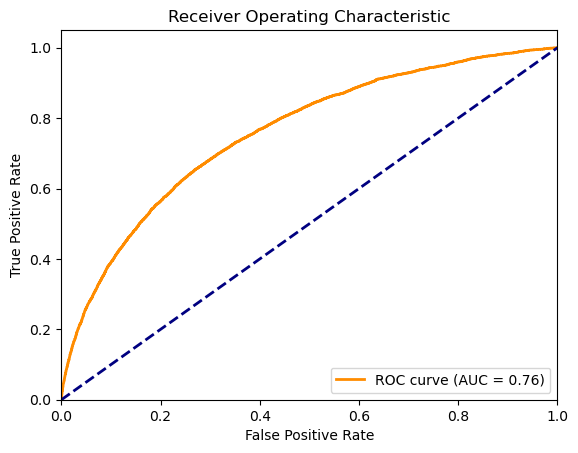

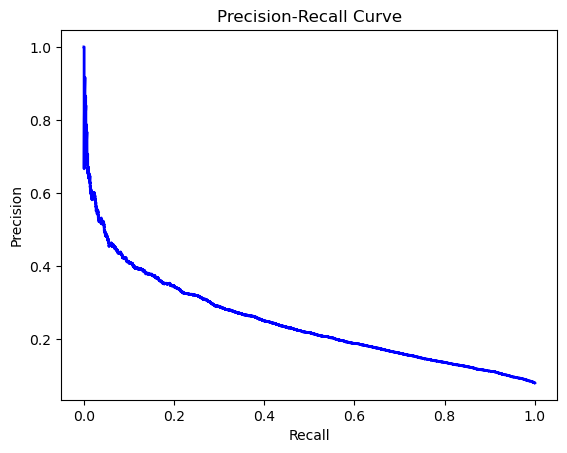

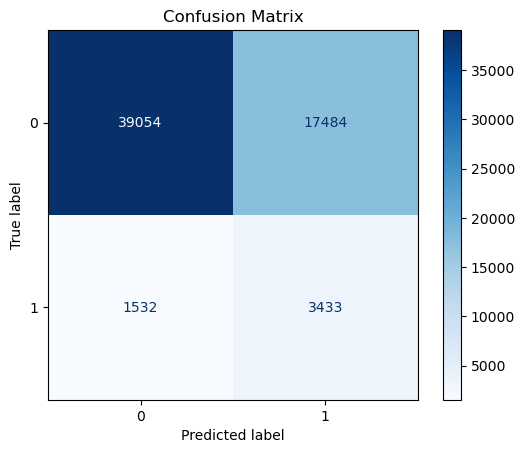

In [22]:
results_eval = evaluate_model(best_model, X_test, y_test, metrics)
print('Métriques du meilleur modèle :')
for k, v in results_eval.items():
    print(f'{k}: {v:.4f}')

plot_roc_curve(best_model, X_test, y_test)
plot_precision_recall_curve(best_model, X_test, y_test)
plot_confusion_matrix(best_model, X_test, y_test)

## 8. Sauvegarde du meilleur modèle

On sauvegarde le modèle pour une utilisation future.

In [23]:
save_model(best_model, '../models/best_model.joblib')
print('Modèle sauvegardé dans ../models/best_model.joblib')

Modèle sauvegardé dans ../models/best_model.joblib


## 9. Interprétabilité du modèle

On analyse l'importance des variables et on utilise SHAP pour l'interprétabilité globale et locale.

#### Interprétabilité globale

In [25]:
type(X_test_transformed)

numpy.ndarray

 99%|===================| 60822/61503 [01:07<00:00]        

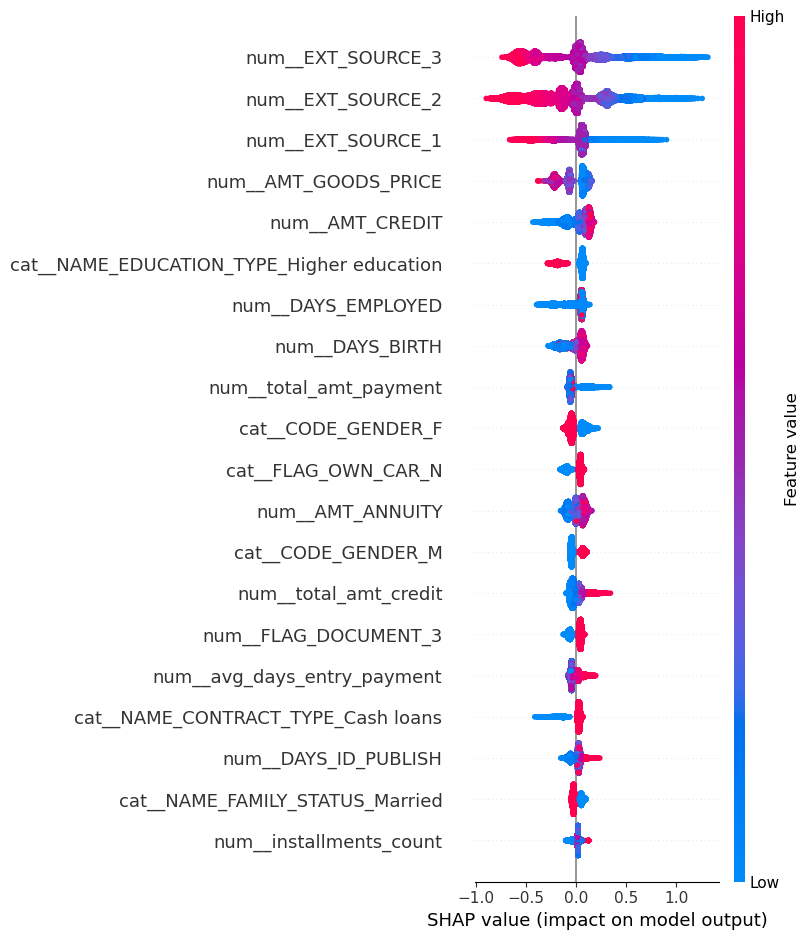

In [28]:
# Récupérer uniquement la partie preprocessing du pipeline
preprocessor = best_model.named_steps['preprocessing']

# Transformer X_test pour avoir des données numériques
X_test_transformed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()
X_trans_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Récupérer le modèle final
model_final = best_model.named_steps['model']

# Créer l'explainer avec les données transformées
explainer = shap.Explainer(model_final, X_trans_df)

# Calculer les valeurs SHAP
shap_values = explainer(X_trans_df,check_additivity=False)

# Afficher le résumé global
shap.summary_plot(shap_values, X_trans_df, max_display=20)


#### Interprétabilité locale

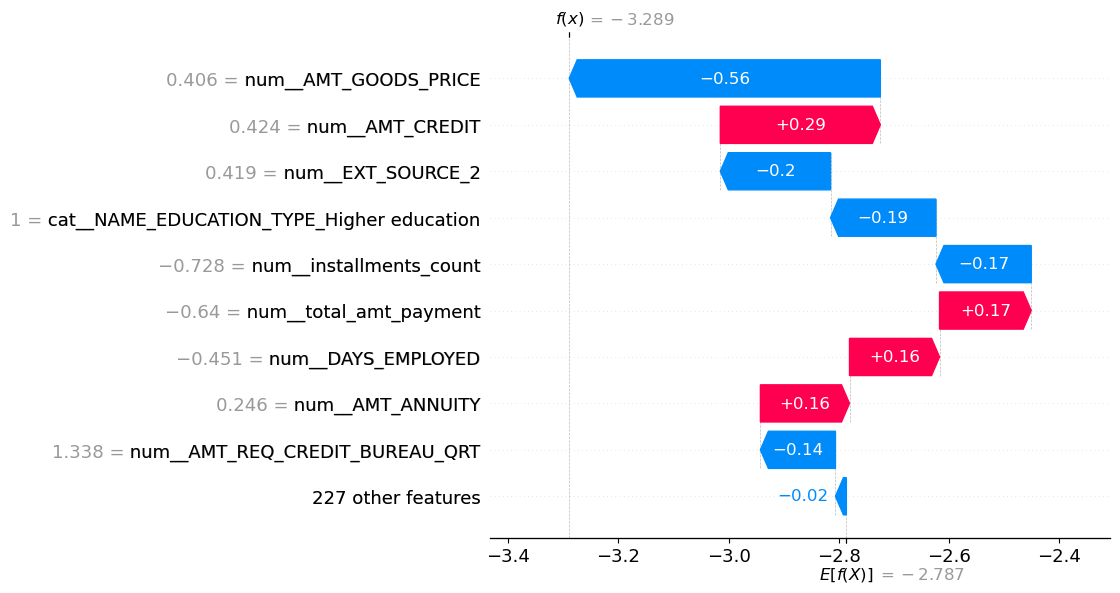

In [57]:
shap.plots.waterfall(shap_values[0]) 